# Gensim Word2Vec Tutorial


<img src="https://images.freeimages.com/images/large-previews/2b9/letters-1-yes-1188348.jpg" alt="drawing" width="350"/>

# Motivation

As I started working at [Supportiv](http://www.supportiv.com), the support network for instant peer support, a few months ago, I began looking into Language Models and Word2Vec particularly. A python native, I naturally decided to focus on Gensim's implementation of Word2Vec, and went on to look for tutorials on the web. As all good data scientists, I directly applied and reproduced the code samples from multiple website. Confused and often disappointed by the results I got, I went deeper and deeper, from stackoverflow threads, to Gensim's Google Groups, onto the documentation of the library, to try and understand what went wrong in my approach. After weeks of hard labor, I finally managed to get decent results, but I was frustrated by these online tutorials which were, for the most part, misleading.

What troubled me the most in these online tutorials was their mismanagement of the model training: the code worked, and I got results which appeared to be decent at first, but the more I looked into them, the more disturbing they were. I wasted a lot of time figuring out what was wrong.

Another issue I had with these tutorials was the data preparation step: too often, the authors chose to load an existing preprocessed dataset, use a toy example or skip this part. However, I always thought that one of the most important parts of the creation of a Word2Vec model was then missing. During my experimentations, I noticed that lemmatizing the sentences or looking for phrases/bigrams in them had a big impact over the results and performance of my models. Though the influence of the preprocessing varies with each dataset and application, I thought I would include the data preparation steps in this tutorial and use the great spaCy library along with it.

I am not the only one annoyed by some of these [issues](https://groups.google.com/d/msg/gensim/jom4JFt7EV8/y5fjhupbAgAJ), so I decided to write my own tutorial.

I do not pledge that it is perfect, nor the best way to implement Word2Vec, simply that it is better than a good chunk of what is out there 😉

# Plan

1. [Briefing about Word2Vec](#Briefing-about-Word2Vec:)
    * [Purpose of the tutorial](#Purpose-of-the-tutorial:)
    * [Brief explanation](#Brief-explanation:)

2. [Getting Started](#Getting-Started)
    * [Setting up the environment](#Setting-up-the-environment:)
    * [The data](#The-data:)
3. [Preprocessing](#Preprocessing)
    * [Cleaning](#Cleaning)
    * [Bigrams](#Bigrams)
    * [Most frequent words](#Most-Frequent-Words)
    
4. [Training the Model](#Training-the-model)
    * [Gensim Word2Vec Implementation](#Gensim-Word2Vec-Implementation:)
    * [Why I seperate the training of the model in 3 steps](#Why-I-seperate-the-training-of-the-model-in-3-steps:)
    * [Training the model](#Training-the-model)
        * [The parameters](#The-parameters)
        * [Building the vocabulary table](#Building-the-Vocabulary-Table)
        * [Training of the model](#Training-of-the-model)
        * [Saving the model](#Saving-the-model:)
5. [Exploring the Model](#Exploring-the-model)
    * [Most similar to](#Most-similar-to:)
    * [Similarities](#Similarities:)
    * [Odd-one-out](#Odd-One-Out:)
    * [Analogy difference](#Analogy-difference:)
    * [t-SNE visualizations](#t-SNE-visualizations:)
        * [10 Most similar words vs. 8 Random words](#10-Most-similar-words-vs.-8-Random-words:)
        * [10 Most similar words vs. 10 Most dissimilar](#10-Most-similar-words-vs.-10-Most-dissimilar:)
        * [10 Most similar words vs. 11th to 20th Most similar words](#10-Most-similar-words-vs.-11th-to-20th-Most-similar-words:)
6. [Final Thoughts](#Final-Thoughts)
7. [Material for more in depths understanding](#Material-for-more-in-depths-understanding:)
8. [Acknowledgements](#Acknowledgements)
9. [References](#References:)
10. [End](#End)

# Briefing about Word2Vec:

<img src="http://mccormickml.com/assets/word2vec/skip_gram_net_arch.png" alt="drawing" width="550"/>

[[1]](#References:)


## Purpose of the tutorial:
As I said before, this tutorial focuses on the right use of the Word2Vec package from the Gensim libray; therefore, I am not going to explain the concepts and ideas behind Word2Vec here. I am simply going to give a very brief explanation, and provide you with links to good, in depth tutorials.

## Brief explanation:

Word2Vec was introduced in two [papers](#Material-for-more-in-depths-understanding:) between September and October 2013, by a team of researchers at Google. Along with the papers, the researchers published their implementation in C. The Python implementation was done soon after the 1st paper, by [Gensim](https://radimrehurek.com/gensim/index.html). 

The underlying assumption of Word2Vec is that two words sharing similar contexts also share a similar meaning and consequently a similar vector representation from the model. For instance: "dog", "puppy" and "pup" are often used in similar situations, with similar surrounding words like "good", "fluffy" or "cute", and according to Word2Vec they will therefore share a similar vector representation.<br>

From this assumption, Word2Vec can be used to find out the relations between words in a dataset, compute the similarity between them, or use the vector representation of those words as input for other applications such as text classification or clustering.

# Getting Started

## Setting up the environment:

`python==3.6.3`

Libraries used:
 * `xlrd==1.1.0`: https://pypi.org/project/xlrd/
 * `spaCy==2.0.12`: https://spacy.io/usage/
 * `gensim==3.4.0`: https://radimrehurek.com/gensim/install.html
 * `scikit-learn==0.19.1`: http://scikit-learn.org/stable/install.html
 * `seaborn==0.8`: https://seaborn.pydata.org/installing.html

In [1]:
import re  # For preprocessing
import pandas as pd  # For data handling
from time import time  # To time our operations
from collections import defaultdict  # For word frequency

import spacy  # For preprocessing

import logging  # Setting up the loggings to monitor gensim
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)

dataset_path = '../../datasets/simpsons_dataset.csv'

<img src="https://upload.wikimedia.org/wikipedia/commons/4/44/Logo_The_Simpsons.svg" alt="drawing" width="400"/>

## The data:
I chose to play with the script from the Simpsons, both because I love the Simpsons and because with more than 150k lines of dialogues, the dataset was substantial!

This dataset contains the characters, locations, episode details, and script lines for approximately 600 Simpsons episodes, dating back to 1989. It can be found here: https://www.kaggle.com/ambarish/fun-in-text-mining-with-simpsons/data (~25MB)

# Preprocessing

We keep only two columns:
* `raw_character_text`: the character who speaks (can be useful when monitoring the preprocessing steps)
* `spoken_words`: the raw text from the line of dialogue

We do not keep `normalized_text` because we want to do our own preprocessing.

You can find the resulting file here: https://www.kaggle.com/pierremegret/dialogue-lines-of-the-simpsons

In [2]:
df = pd.read_csv(dataset_path)
df.shape

(158314, 2)

In [3]:
df.head()

,raw_character_text,spoken_words
0,Miss Hoover,"No, actually, it was a little of both. Sometim..."
1,Lisa Simpson,Where's Mr. Bergstrom?
2,Miss Hoover,I don't know. Although I'd sure like to talk t...
3,Lisa Simpson,That life is worth living.
4,Edna Krabappel-Flanders,The polls will be open from now until the end ...


The missing values comes from the part of the script where something happens, but with no dialogue. For instance "(Springfield Elementary School: EXT. ELEMENTARY - SCHOOL PLAYGROUND - AFTERNOON)"

In [4]:
df.isnull().sum()

raw_character_text    17814
spoken_words          26459
dtype: int64

Removing the missing values:

In [5]:
df = df.dropna().reset_index(drop=True)
df.isnull().sum()

raw_character_text    0
spoken_words          0
dtype: int64

## Cleaning:
We are lemmatizing and removing the stopwords and non-alphabetic characters for each line of dialogue.

In [6]:
df.raw_character_text.value_counts()

Homer Simpson            27850
Marge Simpson            13172
Bart Simpson             12995
Lisa Simpson             10756
C. Montgomery Burns       3077
                         ...  
Basketball Player            1
Oboist                       1
Father In Burlap Sack        1
Shelbyvillians               1
Voice From Diorama           1
Name: raw_character_text, Length: 6272, dtype: int64

In [7]:
nlp = spacy.load('en_core_web_sm', disable=['ner', 'parser']) # disabling Named Entity Recognition for speed

def cleaning(doc):
    # Lemmatizes and removes stopwords
    # doc needs to be a spacy Doc object
    txt = [token.lemma_ for token in doc if not token.is_stop]
    # Word2Vec uses context words to learn the vector representation of a target word,
    # if a sentence is only one or two words long,
    # the benefit for the training is very small
    if len(txt) > 2:
        return ' '.join(txt)

Removes non-alphabetic characters:

In [8]:
brief_cleaning = (re.sub("[^A-Za-z']+", ' ', str(row)).lower() for row in df['spoken_words'])

In [9]:
brief_cleaning

<generator object <genexpr> at 0x7f0684fc9c10>

Taking advantage of spaCy .pipe() attribute to speed-up the cleaning process:

In [10]:
t = time()

txt = [cleaning(doc) for doc in nlp.pipe(brief_cleaning, batch_size=5000, n_process=-1)]

print('Time to clean up everything: {} mins'.format(round((time() - t) / 60, 2)))

Time to clean up everything: 0.95 mins


Put the results in a DataFrame to remove missing values and duplicates:

In [11]:
df_clean = pd.DataFrame({'clean': txt})
df_clean = df_clean.dropna().drop_duplicates()
df_clean.shape

(85952, 1)

## Bigrams:
We are using Gensim Phrases package to automatically detect common phrases (bigrams) from a list of sentences.
https://radimrehurek.com/gensim/models/phrases.html

The main reason we do this is to catch words like "mr_burns" or "bart_simpson" !

In [12]:
from gensim.models.phrases import Phrases, Phraser

INFO - 15:18:35: 'pattern' package not found; tag filters are not available for English


As `Phrases()` takes a list of list of words as input:

In [13]:
sent = [row.split() for row in df_clean['clean']]

Creates the relevant phrases from the list of sentences:

In [14]:
phrases = Phrases(sent, min_count=30, progress_per=10000)

INFO - 15:18:37: collecting all words and their counts
INFO - 15:18:37: PROGRESS: at sentence #0, processed 0 words and 0 word types
INFO - 15:18:37: PROGRESS: at sentence #10000, processed 63557 words and 52763 word types
INFO - 15:18:37: PROGRESS: at sentence #20000, processed 130938 words and 99744 word types
INFO - 15:18:37: PROGRESS: at sentence #30000, processed 192959 words and 138351 word types
INFO - 15:18:37: PROGRESS: at sentence #40000, processed 249832 words and 172387 word types
INFO - 15:18:37: PROGRESS: at sentence #50000, processed 311271 words and 208254 word types
INFO - 15:18:37: PROGRESS: at sentence #60000, processed 373576 words and 243325 word types
INFO - 15:18:37: PROGRESS: at sentence #70000, processed 436427 words and 278322 word types
INFO - 15:18:38: PROGRESS: at sentence #80000, processed 497902 words and 311462 word types
INFO - 15:18:38: collected 330189 word types from a corpus of 537083 words (unigram + bigrams) and 85952 sentences
INFO - 15:18:38: us

The goal of Phraser() is to cut down memory consumption of Phrases(), by discarding model state not strictly needed for the bigram detection task:

In [15]:
bigram = Phraser(phrases)

INFO - 15:18:38: source_vocab length 330189
INFO - 15:18:39: Phraser built with 127 phrasegrams


Transform the corpus based on the bigrams detected:

In [16]:
sentences = bigram[sent]

## Most Frequent Words:
Mainly a sanity check of the effectiveness of the lemmatization, removal of stopwords, and addition of bigrams.

In [17]:
word_freq = defaultdict(int)
for sent in sentences:
    for i in sent:
        word_freq[i] += 1
len(word_freq)

29651

In [18]:
sorted(word_freq, key=word_freq.get, reverse=True)[:10]

['oh', 'like', 'know', 'get', 'hey', 'think', 'come', 'right', 'look', 'want']

# Training the model
## Gensim Word2Vec Implementation:
We use Gensim implementation of word2vec: https://radimrehurek.com/gensim/models/word2vec.html

In [19]:
import multiprocessing

from gensim.models import Word2Vec

## Why I seperate the training of the model in 3 steps:
I prefer to separate the training in 3 distinctive steps for clarity and monitoring.
1. `Word2Vec()`: 
>In this first step, I set up the parameters of the model one-by-one. <br>I do not supply the parameter `sentences`, and therefore leave the model uninitialized, purposefully.
2. `.build_vocab()`: 
>Here it builds the vocabulary from a sequence of sentences and thus initialized the model. <br>With the loggings, I can follow the progress and even more important, the effect of `min_count` and `sample` on the word corpus. I noticed that these two parameters, and in particular `sample`, have a great influence over the performance of a model. Displaying both allows for a more accurate and an easier management of their influence.
3. `.train()`:
>Finally, trains the model.<br>
The loggings here are mainly useful for monitoring, making sure that no threads are executed instantaneously.

In [20]:
cores = multiprocessing.cpu_count() # Count the number of cores in a computer

## The parameters:

* `min_count` <font color='purple'>=</font> <font color='green'>int</font> - Ignores all words with total absolute frequency lower than this - (2, 100)


* `window` <font color='purple'>=</font> <font color='green'>int</font> - The maximum distance between the current and predicted word within a sentence. E.g. `window` words on the left and `window` words on the left of our target - (2, 10)


* `size` <font color='purple'>=</font> <font color='green'>int</font> - Dimensionality of the feature vectors. - (50, 300)


* `sample` <font color='purple'>=</font> <font color='green'>float</font> - The threshold for configuring which higher-frequency words are randomly downsampled. Highly influencial.  - (0, 1e-5)


* `alpha` <font color='purple'>=</font> <font color='green'>float</font> - The initial learning rate - (0.01, 0.05)


* `min_alpha` <font color='purple'>=</font> <font color='green'>float</font> - Learning rate will linearly drop to `min_alpha` as training progresses. To set it: alpha - (min_alpha * epochs) ~ 0.00


* `negative` <font color='purple'>=</font> <font color='green'>int</font> - If > 0, negative sampling will be used, the int for negative specifies how many "noise words" should be drown. If set to 0, no negative sampling is used. - (5, 20)


* `workers` <font color='purple'>=</font> <font color='green'>int</font> - Use these many worker threads to train the model (=faster training with multicore machines)

In [21]:
w2v_model = Word2Vec(min_count=20,
                     window=2,
                     size=300,
                     sample=6e-5, 
                     alpha=0.03, 
                     min_alpha=0.0007, 
                     negative=20,
                     workers=cores-1)

## Building the Vocabulary Table:
Word2Vec requires us to build the vocabulary table (simply digesting all the words and filtering out the unique words, and doing some basic counts on them):

In [22]:
t = time()

w2v_model.build_vocab(sentences, progress_per=10000)

print('Time to build vocab: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:18:41: collecting all words and their counts
INFO - 15:18:41: PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
INFO - 15:18:41: PROGRESS: at sentence #10000, processed 61694 words, keeping 9501 word types
INFO - 15:18:41: PROGRESS: at sentence #20000, processed 127310 words, keeping 14369 word types
INFO - 15:18:41: PROGRESS: at sentence #30000, processed 187765 words, keeping 17424 word types
INFO - 15:18:41: PROGRESS: at sentence #40000, processed 243261 words, keeping 20100 word types
INFO - 15:18:41: PROGRESS: at sentence #50000, processed 303119 words, keeping 22539 word types
INFO - 15:18:42: PROGRESS: at sentence #60000, processed 363855 words, keeping 24790 word types
INFO - 15:18:42: PROGRESS: at sentence #70000, processed 425313 words, keeping 26965 word types
INFO - 15:18:42: PROGRESS: at sentence #80000, processed 485446 words, keeping 28786 word types
INFO - 15:18:42: collected 29651 word types from a corpus of 523523 raw words and 85952 sentence

Time to build vocab: 0.02 mins


## Training of the model:
_Parameters of the training:_
* `total_examples` <font color='purple'>=</font> <font color='green'>int</font> - Count of sentences;
* `epochs` <font color='purple'>=</font> <font color='green'>int</font> - Number of iterations (epochs) over the corpus - [10, 20, 30]

In [23]:
t = time()

w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

print('Time to train the model: {} mins'.format(round((time() - t) / 60, 2)))

INFO - 15:18:42: training model with 11 workers on 3323 vocabulary and 300 features, using sg=0 hs=0 sample=6e-05 negative=20 window=2
INFO - 15:18:43: EPOCH 1 - PROGRESS: at 82.31% examples, 163092 words/s, in_qsize 0, out_qsize 0
INFO - 15:18:44: worker thread finished; awaiting finish of 10 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 9 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 8 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 7 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 6 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 5 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 4 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 3 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 2 more threads
INFO - 15:18:44: worker thread finished; awaiting finish of 1 more threads
INFO - 15:18:44: 

Time to train the model: 0.66 mins


As we do not plan to train the model any further, we are calling init_sims(), which will make the model much more memory-efficient:

In [24]:
w2v_model.init_sims(replace=True)

INFO - 15:19:22: precomputing L2-norms of word weight vectors


# Exploring the model
## Most similar to:

Here, we will ask our model to find the word most similar to some of the most iconic characters of the Simpsons!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/02/Homer_Simpson_2006.png/revision/latest?cb=20091207194310" alt="drawing" width="130"/>

Let's see what we get for the show's main character:

In [25]:
w2v_model.wv.most_similar(positive=["homer"])

[('snuggle', 0.7818065881729126),
 ('marge', 0.7727758884429932),
 ('crummy', 0.7702572345733643),
 ('sweetheart', 0.7591434121131897),
 ('hammock', 0.7587664723396301),
 ('bongo', 0.7530314326286316),
 ('gramma', 0.7520074844360352),
 ('gee', 0.7489525079727173),
 ('ralphie', 0.7463264465332031),
 ('rude', 0.7452852725982666)]

_A small precision here:_<br>
The dataset is the Simpsons' lines of dialogue; therefore, when we look at the most similar words from "homer" we do **not** necessary get his family members, personality traits, or even his most quotable words. No, we get what other characters (as Homer does not often refers to himself at the 3rd person) said along with "homer", such as how he feels or looks ("depressed"), where he is ("hammock"), or with whom ("marge").

Let's see what the bigram "homer_simpson" gives us by comparison:

In [26]:
w2v_model.wv.most_similar(positive=["homer_simpson"])

[('charles', 0.7525602579116821),
 ('brief', 0.7429357767105103),
 ('easily', 0.7404719591140747),
 ('recent', 0.7358390092849731),
 ('simon', 0.7340440154075623),
 ('pleased', 0.7339122295379639),
 ('council', 0.7335614562034607),
 ('robert', 0.7321640253067017),
 ('governor', 0.7300623655319214),
 ('speaker', 0.7278479933738708)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/0/0b/Marge_Simpson.png/revision/latest?cb=20180626055729" alt="drawing" width="150"/>

What about Marge now?

In [27]:
w2v_model.wv.most_similar(positive=["marge"])

[('homie', 0.7728767991065979),
 ('homer', 0.7727760076522827),
 ('sorry', 0.7695120573043823),
 ('snuggle', 0.7693957686424255),
 ('gosh', 0.7688096761703491),
 ('rude', 0.7624812722206116),
 ('attract', 0.7503890991210938),
 ('becky', 0.7499066591262817),
 ('husband', 0.7496970295906067),
 ('hammock', 0.7434624433517456)]

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/65/Bart_Simpson.png/revision/latest?cb=20180319061933" alt="drawing" width="100"/>

Let's check Bart now:

In [28]:
w2v_model.wv.most_similar(positive=["bart"])

[('lisa', 0.8751772046089172),
 ('hearing', 0.8224157691001892),
 ('convince', 0.8095096349716187),
 ('strangle', 0.7903499603271484),
 ('homework', 0.7869150042533875),
 ('mom', 0.7841330170631409),
 ('muntz', 0.782673716545105),
 ('jealous', 0.7814770340919495),
 ('concerned', 0.7795873284339905),
 ('selfish', 0.7791162729263306)]

Looks like it is making sense!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/9d/Groundskeeper_Willie.png/revision/latest?cb=20130424154035" alt="drawing" width="150"/>

Willie the groundskeeper for the last one:

## Similarities:
Here, we will see how similar are two words to each other :

In [29]:
w2v_model.wv.similarity("moe_'s", 'tavern')

KeyError: "word 'moe_'s' not in vocabulary"

Who could forget Moe's tavern? Not Barney.

<img src="https://vignette.wikia.nocookie.net/simpsons/images/6/6c/MaggieSimpson.PNG/revision/latest?cb=20180314210204" alt="drawing" width="100"/>

In [30]:
w2v_model.wv.similarity('maggie', 'baby')

0.7098925

Maggie is indeed the most renown baby in the Simpsons!

In [31]:
w2v_model.wv.similarity('bart', 'nelson')

0.6826195

Bart and Nelson, though friends, are not that close, makes sense!

## Odd-One-Out:

Here, we ask our model to give us the word that does not belong to the list!

Between Jimbo, Milhouse, and Kearney, who is the one who is not a bully?

In [32]:
w2v_model.wv.doesnt_match(['jimbo', 'milhouse', 'kearney'])

WARNING - 15:19:45: vectors for words {'kearney'} are not present in the model, ignoring these words
/home/shakabrah/.local/lib/python3.8/site-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)


'milhouse'

Milhouse of course!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/9/91/Milhouse_Van_Houten_2.png/revision/latest?cb=20180429212659" alt="drawing" width="150"/>

What if we compared the friendship between Nelson, Bart, and Milhouse?

In [33]:
w2v_model.wv.doesnt_match(["nelson", "bart", "milhouse"])

'nelson'

Seems like Nelson is the odd one here!

<img src="https://vignette.wikia.nocookie.net/simpsons/images/4/40/Picture0003.jpg/revision/latest?cb=20110623042517" alt="drawing" width="200"/>

Last but not least, how is the relationship between Homer and his two sister-in-laws?

In [ ]:
w2v_model.wv.doesnt_match(['homer', 'patty', 'selma'])

Damn, they really do not like you Homer!

## Analogy difference:
Which word is to woman as homer is to marge?

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "homer"], negative=["marge"], topn=3)

"man" comes at the first position, that looks about right!

Which word is to woman as bart is to man?

In [ ]:
w2v_model.wv.most_similar(positive=["woman", "bart"], negative=["man"], topn=3)

Lisa is Bart's sister, her male counterpart!
<img src="https://vignette.wikia.nocookie.net/simpsons/images/5/57/Lisa_Simpson2.png/revision/latest?cb=20180319000458" alt="drawing" width="100"/>

### t-SNE visualizations:
t-SNE is a non-linear dimensionality reduction algorithm that attempts to represent high-dimensional data and the underlying relationships between vectors in a lower-dimensional space.<br>
Here is a good tutorial on it: https://medium.com/@luckylwk/visualising-high-dimensional-datasets-using-pca-and-t-sne-in-python-8ef87e7915b

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
 
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

Our goal in this section is to plot our 300 dimensions vectors into 2 dimensional graphs, and see if we can spot interesting patterns.<br>
For that we are going to use t-SNE implementation from scikit-learn.

To make the visualizations more relevant, we will look at the relationships between a query word (in <font color='red'>**red**</font>), its most similar words in the model (in <font color="blue">**blue**</font>), and other words from the vocabulary (in <font color='green'>**green**</font>).

In [38]:
def tsnescatterplot(model, word, list_names):
    """ Plot in seaborn the results from the t-SNE dimensionality reduction algorithm of the vectors of a query word,
    its list of most similar words, and a list of words.
    """
    arrays = np.empty((0, 300), dtype='f')
    word_labels = [word]
    color_list  = ['red']

    # adds the vector of the query word
    arrays = np.append(arrays, model.wv.__getitem__([word]), axis=0)
    
    # gets list of most similar words
    close_words = model.wv.most_similar([word])
    
    # adds the vector for each of the closest words to the array
    for wrd_score in close_words:
        wrd_vector = model.wv.__getitem__([wrd_score[0]])
        word_labels.append(wrd_score[0])
        color_list.append('blue')
        arrays = np.append(arrays, wrd_vector, axis=0)
    
    # adds the vector for each of the words from list_names to the array
    for wrd in list_names:
        wrd_vector = model.wv.__getitem__([wrd])
        word_labels.append(wrd)
        color_list.append('green')
        arrays = np.append(arrays, wrd_vector, axis=0)
        
    # Reduces the dimensionality from 300 to 50 dimensions with PCA
    reduc = PCA(n_components=19).fit_transform(arrays)
    
    # Finds t-SNE coordinates for 2 dimensions
    np.set_printoptions(suppress=True)
    
    Y = TSNE(n_components=2, random_state=0, perplexity=15).fit_transform(reduc)
    
    # Sets everything up to plot
    df = pd.DataFrame({'x': [x for x in Y[:, 0]],
                       'y': [y for y in Y[:, 1]],
                       'words': word_labels,
                       'color': color_list})
    
    fig, _ = plt.subplots()
    fig.set_size_inches(9, 9)
    
    # Basic plot
    p1 = sns.regplot(data=df,
                     x="x",
                     y="y",
                     fit_reg=False,
                     marker="o",
                     scatter_kws={'s': 40,
                                  'facecolors': df['color']
                                 }
                    )
    
    # Adds annotations one by one with a loop
    for line in range(0, df.shape[0]):
         p1.text(df["x"][line],
                 df['y'][line],
                 '  ' + df["words"][line].title(),
                 horizontalalignment='left',
                 verticalalignment='bottom', size='medium',
                 color=df['color'][line],
                 weight='normal'
                ).set_size(15)

    
    plt.xlim(Y[:, 0].min()-50, Y[:, 0].max()+50)
    plt.ylim(Y[:, 1].min()-50, Y[:, 1].max()+50)
            
    plt.title('t-SNE visualization for {}'.format(word.title()))
    

Code inspired by: [[2]](#References:)

## 10 Most similar words vs. 8 Random words:
Let's compare where the vector representation of Homer, his 10 most similar words from the model, as well as 8 random ones, lies in a 2D graph:

/home/shakabrah/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/shakabrah/.local/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


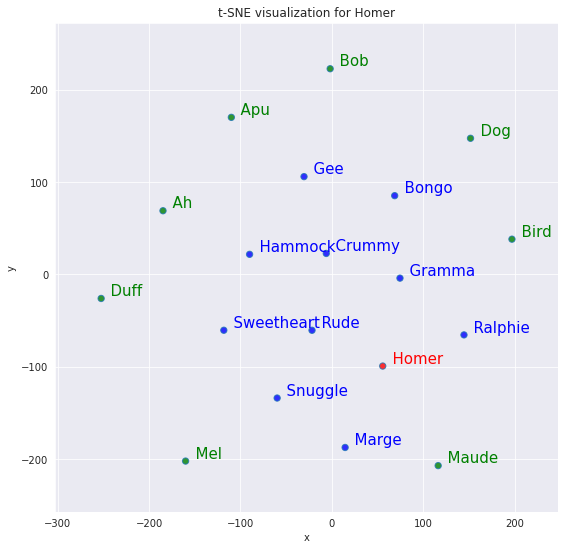

In [39]:
tsnescatterplot(w2v_model, 'homer', ['dog', 'bird', 'ah', 'maude', 'bob', 'mel', 'apu', 'duff'])

Interestingly, the 10 most similar words to Homer ends up around him, so does Apu and (sideshow) Bob, two recurrent characters.

## 10 Most similar words vs. 10 Most dissimilar

This time, let's compare where the vector representation of Maggie and her 10 most similar words from the model lies compare to the vector representation of the 10 most dissimilar words to Maggie:

In [ ]:
tsnescatterplot(w2v_model, 'maggie', [i[0] for i in w2v_model.wv.most_similar(negative=["maggie"])])

Neat! Maggie and her most similar words form a distinctive cluster from the most dissimilar words, it is a really encouraging plot!

## 10 Most similar words vs. 11th to 20th Most similar words:

Finally, we are going to plot the most similar words to Mr. Burns ranked 1st to 10th versus the ones ranked 11th to 20th:

(PS: Mr. Burns became mr_burn after the preprocessing)

In [ ]:
tsnescatterplot(w2v_model, "mr_burn", [t[0] for t in w2v_model.wv.most_similar(positive=["mr_burn"], topn=20)][10:])

As we can see, and that is very nice, all the 20 words are forming one cluster around Mr. Burns.

# Final Thoughts

I hope you found this tutorial useful and had as much fun reading it as I had writing it. Please do not hesitate to leave any comments, questions or suggestions you might have. See you around!

Also, please check [Supportiv](http://www.supportiv.com) around! (Simpson-ized logo)

<img src="https://fontmeme.com/permalink/180904/cc3d27a8aaa88189e764ee9d02331d0d.png" alt="drawing" width="500"/>


# Materials for more in depths understanding:
* Word Embeddings introduction: https://www.analyticsvidhya.com/blog/2017/06/word-embeddings-count-word2veec/
* Word2Vec introduction: https://skymind.ai/wiki/word2vec
* Another Word2Vec introduction: http://mccormickml.com/2016/04/19/word2vec-tutorial-the-skip-gram-model/
* A great Gensim implentation tutorial: http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W467ScBjM2x
* Original articles from Mikolov et al.: https://arxiv.org/abs/1301.3781 and https://arxiv.org/abs/1310.4546


# Acknowledgements

* [Pouria Mojabi](https://www.linkedin.com/in/pouria-mojabi-1873615/), co-fouder of Supportiv Inc.

# References:
* [1]. Neural Net picture: McCormick, C. (2016, April 19). Word2Vec Tutorial - The Skip-Gram Model. Retrieved from http://www.mccormickml.com
* [2]. Aneesha Bakharia Medium article: https://medium.com/@aneesha/using-tsne-to-plot-a-subset-of-similar-words-from-word2vec-bb8eeaea6229

# End